In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from matplotlib import pyplot
import shap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import json
pd.set_option('display.max_columns', 1000)

# Objective

* In the last notebook we create our baseline model including a feature selection part. 
* Cohen cappa score of 0.456 (lb) with a local cv score of 0.529
* In this notebook we are going to add more features and remove others that i think they overfitt the train set and then check if our local cv score improve.
* Next, we will check if this improvement aligns with the lb.

# Notes
* Check the distribution of the target variable of the out of folds score and the prediction distribution. A good model should more or less have the same distribution.

In [2]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [3]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [4]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('../data-science-bowl-2019/train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('../data-science-bowl-2019/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('../data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('../data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('../data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [5]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [6]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features['installation_session_count'] = sessions_count
            
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                 
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [7]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [8]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model

In [9]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100
                    }
        return params

In [10]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000}

        return params

In [11]:
class Catb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        clf = CatBoostRegressor(**self.params)
        clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=(val_set['X'], val_set['y']),
                verbose=verbosity, 
                cat_features=self.categoricals)
        return clf
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        params = {'loss_function': 'RMSE',
                   'task_type': "CPU",
                   'iterations': 5000,
                   'od_type': "Iter",
                    'depth': 10,
                  'colsample_bylevel': 0.5, 
                   'early_stopping_rounds': 300,
                    'l2_leaf_reg': 18,
                   'random_seed': 42,
                    'use_best_model': True,
                  
                    }
        return params

In [12]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

class Nn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.get_feature_names()]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        print(train_df[features].shape)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set['X'].shape[1],)),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='relu')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/paniquex/anaconda3/envs/kaggle/lib

In [13]:
from random import choice

class Cnn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.get_feature_names()]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        self.create_feat_2d(features)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def create_feat_2d(self, features, n_feats_repeat=50):
        self.n_feats = len(features)
        self.n_feats_repeat = n_feats_repeat
        self.mask = np.zeros((self.n_feats_repeat, self.n_feats), dtype=np.int32)
        for i in range(self.n_feats_repeat):
            l = list(range(self.n_feats))
            for j in range(self.n_feats):
                c = l.pop(choice(range(len(l))))
                self.mask[i, j] = c
        self.mask = tf.convert_to_tensor(self.mask)
        print(self.mask.shape)
       
        
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0

        inp = tf.keras.layers.Input(shape=(self.n_feats))
        x = tf.keras.layers.Lambda(lambda x: tf.gather(x, self.mask, axis=1))(inp)
        x = tf.keras.layers.Reshape((self.n_feats_repeat, self.n_feats, 1))(x)
        x = tf.keras.layers.Conv2D(18, (50, 50), strides=50, activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(200, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(100, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(50, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        out = tf.keras.layers.Dense(1)(x)
        
        model = tf.keras.Model(inp, out)
    
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [14]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode

train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0.0026939774600629332


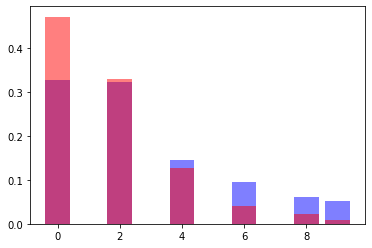

0.0026939774600629332

In [15]:
def stract_hists(feature, train=reduce_train, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre
stract_hists('Magma Peak - Level 1_2000', adjust=False, plot=True)

In [16]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [17]:
counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
            if c > 0.995:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

1: FEAT_A: Clip FEAT_B: 27253bdc - Correlation: 0.9999999999999974
2: FEAT_A: 2050 FEAT_B: 2040 - Correlation: 0.9965259434877979
3: FEAT_A: 2050 FEAT_B: dcaede90 - Correlation: 0.9965259434877979
4: FEAT_A: 2050 FEAT_B: 73757a5e - Correlation: 0.9998050146714084
5: FEAT_A: 2050 FEAT_B: 2b9272f4 - Correlation: 0.9999839030068794
6: FEAT_A: 2050 FEAT_B: 26fd2d99 - Correlation: 0.996508454399599
7: FEAT_A: 2050 FEAT_B: 37c53127 - Correlation: 1.0
8: FEAT_A: 2050 FEAT_B: 08fd73f3 - Correlation: 0.9966123918733648
9: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2050 - Correlation: 1.0
10: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2020 - Correlation: 0.996508454399599
11: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3021 - Correlation: 0.9998050146714084
12: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3121 - Correlation: 0.9999839030068794
13: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2040 - Correlation: 0.9965259434877979
14: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2030 - Correlation: 0.9966123918733648
15: FEAT_A: 3110 FEAT_B: 3010 - Correlation: 

113: FEAT_A: 58a0de5c FEAT_B: f5b8c21a - Correlation: 0.9977888184538098
114: FEAT_A: 58a0de5c FEAT_B: 9b4001e4 - Correlation: 0.9999159362216106
115: FEAT_A: 58a0de5c FEAT_B: Air Show_3021 - Correlation: 0.9999159362216106
116: FEAT_A: 58a0de5c FEAT_B: Air Show_3121 - Correlation: 0.9999999999999946
117: FEAT_A: 58a0de5c FEAT_B: Air Show_2030 - Correlation: 0.9977888184538098
118: FEAT_A: 5e812b27 FEAT_B: Sandcastle Builder (Activity)_4030 - Correlation: 0.9999999999999966
119: FEAT_A: b2dba42b FEAT_B: 1bb5fbdb - Correlation: 0.9999521729414085
120: FEAT_A: b2dba42b FEAT_B: Sandcastle Builder (Activity)_3010 - Correlation: 0.999999999999937
121: FEAT_A: b2dba42b FEAT_B: Sandcastle Builder (Activity)_3110 - Correlation: 0.9999521729414085
122: FEAT_A: 4901243f FEAT_B: Fireworks (Activity)_2000 - Correlation: 0.9999999999999812
123: FEAT_A: 93edfe2e FEAT_B: Crystals Rule_4090 - Correlation: 0.9999999999999842
124: FEAT_A: 795e4a37 FEAT_B: Cart Balancer (Assessment)_3010 - Correlation: 0

213: FEAT_A: 8ac7cce4 FEAT_B: Leaf Leader_2000 - Correlation: 1.0
214: FEAT_A: 29f54413 FEAT_B: Leaf Leader_2060 - Correlation: 1.0
215: FEAT_A: 5c3d2b2f FEAT_B: Scrub-A-Dub_4020 - Correlation: 0.9999999999999977
216: FEAT_A: e720d930 FEAT_B: 3ddc79c3 - Correlation: 0.9998920962508248
217: FEAT_A: e720d930 FEAT_B: Crystals Rule_3121 - Correlation: 1.0
218: FEAT_A: e720d930 FEAT_B: Crystals Rule_3021 - Correlation: 0.9998920962508248
219: FEAT_A: 0d1da71f FEAT_B: Chow Time_3110 - Correlation: 1.0
220: FEAT_A: b74258a0 FEAT_B: ecaab346 - Correlation: 1.0
221: FEAT_A: b74258a0 FEAT_B: b2e5b0f1 - Correlation: 0.9998494646045443
222: FEAT_A: b74258a0 FEAT_B: Cart Balancer (Assessment)_2030 - Correlation: 1.0
223: FEAT_A: b74258a0 FEAT_B: Cart Balancer (Assessment)_3121 - Correlation: 1.0
224: FEAT_A: b74258a0 FEAT_B: Cart Balancer (Assessment)_2010 - Correlation: 0.9998494646045443
225: FEAT_A: d185d3ea FEAT_B: Chow Time_4035 - Correlation: 1.0
226: FEAT_A: b120f2ac FEAT_B: d45ed6a1 - Corre

319: FEAT_A: 88d4a5be FEAT_B: Mushroom Sorter (Assessment)_3120 - Correlation: 0.9999999999999644
320: FEAT_A: 99abe2bb FEAT_B: Bubble Bath_2080 - Correlation: 1.0
321: FEAT_A: ecc6157f FEAT_B: Cart Balancer (Assessment)_4080 - Correlation: 1.0
322: FEAT_A: 8f094001 FEAT_B: 1beb320a - Correlation: 0.9980774800876895
323: FEAT_A: 8f094001 FEAT_B: Bubble Bath_4045 - Correlation: 1.0
324: FEAT_A: 8f094001 FEAT_B: Bubble Bath_2020 - Correlation: 0.9980774800876895
325: FEAT_A: 857f21c0 FEAT_B: Bubble Bath_4040 - Correlation: 1.0
326: FEAT_A: 262136f4 FEAT_B: Leaf Leader_4020 - Correlation: 1.0
327: FEAT_A: 565a3990 FEAT_B: Bug Measurer (Activity)_4070 - Correlation: 0.9999999999999702
328: FEAT_A: 9ce586dd FEAT_B: Chest Sorter (Assessment)_4035 - Correlation: 1.0
329: FEAT_A: 4a4c3d21 FEAT_B: Bird Measurer (Assessment)_4025 - Correlation: 1.0
330: FEAT_A: 7961e599 FEAT_B: Dino Dive_2020 - Correlation: 0.9999999999999908
331: FEAT_A: 6d90d394 FEAT_B: Scrub-A-Dub_2000 - Correlation: 0.999999

419: FEAT_A: 87d743c1 FEAT_B: Dino Dive_4010 - Correlation: 1.0
420: FEAT_A: d9c005dd FEAT_B: Happy Camel_2000 - Correlation: 0.9999999999999596
421: FEAT_A: dcb55a27 FEAT_B: Air Show_4110 - Correlation: 1.0
422: FEAT_A: 19967db1 FEAT_B: Chow Time_4090 - Correlation: 1.0
423: FEAT_A: 93b353f2 FEAT_B: Chest Sorter (Assessment)_4100 - Correlation: 1.0
424: FEAT_A: 804ee27f FEAT_B: Pan Balance_4020 - Correlation: 0.9999999999999618
425: FEAT_A: 47f43a44 FEAT_B: Flower Waterer (Activity)_4090 - Correlation: 0.9999999999999764
426: FEAT_A: 51311d7a FEAT_B: Dino Drink_2000 - Correlation: 1.0
427: FEAT_A: 06372577 FEAT_B: Air Show_2060 - Correlation: 1.0
428: FEAT_A: c7128948 FEAT_B: Mushroom Sorter (Assessment)_4040 - Correlation: 1.0
429: FEAT_A: 363c86c9 FEAT_B: Bug Measurer (Activity)_4035 - Correlation: 1.0
430: FEAT_A: 8af75982 FEAT_B: Happy Camel_4020 - Correlation: 0.999999999999996
431: FEAT_A: 99ea62f3 FEAT_B: Bubble Bath_2083 - Correlation: 0.9999999999999827
432: FEAT_A: 7dfe6d8a 

In [18]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

acc_Cart Balancer (Assessment) -0.04020325710970116 -0.47065833333333346 0.006732930476733109
4074bac2 0.0 0.0
0ce40006 0.0008479366873940079 0.0
1b54d27f 0.0007348784624081402 0.0
5dc079d8 0.0 0.0
7fd1ac25 0.01978518937252685 0.0
bfc77bd6 0.012832108535895986 0.0
003cd2ee 0.0 0.0
29a42aea 0.004070096099491238 0.0
2ec694de 0.008988128886376484 0.0
ecc6157f 0.007292255511588468 0.0
611485c5 0.0013566986998304127 0.0
dcb1663e 0.0 0.0
e4d32835 0.0013001695873374789 0.0
119b5b02 0.0002826455624646693 0.0
ab4ec3a4 0.0009044657998869418 0.0
6aeafed4 0.14703222159412097 0.008 0.0
13f56524 0.04392312040700961 0.0
a8cc6fec 0.0 0.0
01ca3a3c 0.0004522328999434709 0.0
17ca3959 0.0 0.0
eb2c19cd 0.17382702091577162 0.008 0.0
Egg Dropper (Activity)_4080 0.01978518937252685 0.0
Mushroom Sorter (Assessment)_4090 0.17382702091577162 0.008 0.0
Pan Balance_4080 0.0013001695873374789 0.0
Chest Sorter (Assessment)_4080 0.012832108535895986 0.0
Bug Measurer (Activity)_4080 0.008988128886376484 0.0
Bottle Fil

In [19]:
features = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features].shape

(17690, 365)

In [20]:
pseudolabels = pd.read_csv('pseudolabeling_543.csv', index_col=0)

reduce_train = pd.concat([reduce_train, reduce_test], axis=0, sort=True).reset_index().drop(columns='index')

In [21]:
np.argmax(reduce_train.columns == 'accuracy_group')

894

In [22]:
reduce_train.iloc[-1000:, 894] = np.mean(pseudolabels.values, axis=1)

In [23]:
reduce_train['accuracy_group']

0        3.0
1        0.0
2        3.0
3        2.0
4        3.0
        ... 
18685    3.0
18686    0.0
18687    3.0
18688    1.0
18689    1.0
Name: accuracy_group, Length: 18690, dtype: float64

In [24]:
reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
reduce_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_test.columns]
ajusted_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in ajusted_test.columns]

features = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features]
categoricals = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in categoricals]

In [25]:
# coefs = [1.2641475186120315, 1.7026714246402963, 1.9379324492578078]

def soft2hard(o):
    if o < coefs[0]: return 0
    elif o < coefs[1]: return 1
    elif o < coefs[2]: return 2
    else: return 3
    
# _targs = np.array([soft2hard(o.item()) for o in reduce_train.iloc[-1000:, 894].values])

In [26]:
# reduce_train.iloc[-1000:, 894] = _targs

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.02021	valid_1's rmse: 1.03921
[200]	training's rmse: 0.951541	valid_1's rmse: 0.991515
[300]	training's rmse: 0.917315	valid_1's rmse: 0.976799
[400]	training's rmse: 0.893847	valid_1's rmse: 0.970169
[500]	training's rmse: 0.875085	valid_1's rmse: 0.967379
[600]	training's rmse: 0.858912	valid_1's rmse: 0.966294
[700]	training's rmse: 0.844418	valid_1's rmse: 0.965552
[800]	training's rmse: 0.830916	valid_1's rmse: 0.965107
[900]	training's rmse: 0.818491	valid_1's rmse: 0.964886
[1000]	training's rmse: 0.806739	valid_1's rmse: 0.964804
[1100]	training's rmse: 0.795693	valid_1's rmse: 0.964982
Early stopping, best iteration is:
[1020]	training's rmse: 0.804454	valid_1's rmse: 0.964674
Partial score of fold 0 is: 0.6108378847732883
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.02147	valid_1's rmse: 1.03691
[200]	training's rmse: 0.953821	valid_1's rmse: 0.9866

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.8561	val-rmse:1.8572
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.01096	val-rmse:1.14649
[200]	train-rmse:0.743492	val-rmse:1.00588
[300]	train-rmse:0.642321	val-rmse:0.984222
[400]	train-rmse:0.57696	val-rmse:0.979642
[500]	train-rmse:0.541449	val-rmse:0.979738
Stopping. Best iteration:
[451]	train-rmse:0.557472	val-rmse:0.979247

Partial score of fold 0 is: 0.5989835122468
[0]	train-rmse:1.85619	val-rmse:1.85752
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.01026	val-rmse:1.14786
[200]	train-rmse:0.745992	val-rmse:0.999856
[300]	train-rmse:0.645115	val-rmse:0.973517
[400]	train-rmse:0.586257	val-rmse:0.968563
[500]	train-rmse:0.550723	val-rmse:0.969006
Stopping. Best iteration:
[403]	train-rmse:0.585076	val-rmse:0.968517

Partial score of f

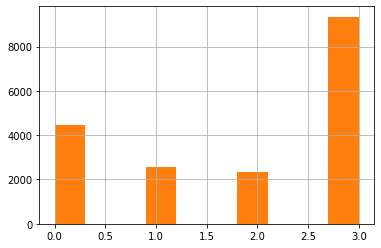

In [27]:
# cat_model = Catb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
xgb_model = Xgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01305	valid_1's rmse: 1.03181
[200]	training's rmse: 0.945222	valid_1's rmse: 0.984044
[300]	training's rmse: 0.911401	valid_1's rmse: 0.968491
[400]	training's rmse: 0.888672	valid_1's rmse: 0.962504
[500]	training's rmse: 0.870158	valid_1's rmse: 0.959807
[600]	training's rmse: 0.854535	valid_1's rmse: 0.958539
[700]	training's rmse: 0.84055	valid_1's rmse: 0.957503
[800]	training's rmse: 0.827614	valid_1's rmse: 0.957132
[900]	training's rmse: 0.815627	valid_1's rmse: 0.957259
Early stopping, best iteration is:
[803]	training's rmse: 0.827204	valid_1's rmse: 0.957065
Partial score of fold 0 is: 0.5929414645971569
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01249	valid_1's rmse: 1.0395
[200]	training's rmse: 0.94475	valid_1's rmse: 0.992346
[300]	training's rmse: 0.91194	valid_1's rmse: 0.97736
[400]	training's rmse: 0.889299	valid_1's rmse: 0.970344
[500]	training's rmse: 0.870961	valid_1's rmse: 0.966998
[600]	training's rmse: 0.855208	valid_1's rmse: 0.965146
[700]	training's rmse: 0.840887	valid_1's rmse: 0.964
[800]	training's rmse: 0.82792	valid_1's rmse: 0.963541
[900]	training's rmse: 0.815865	valid_1's rmse: 0.963003
[1000]	training's rmse: 0.804572	valid_1's rmse: 0.962553
[1100]	training's rmse: 0.793784	valid_1's rmse: 0.962354
Early stopping, best iteration is:
[1062]	training's rmse: 0.797796	valid_1's rmse: 0.962251
Partial score of fold 1 is: 0.6000106301954551
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01729	valid_1's rmse: 1.02876
[200]	training's rmse: 0.949928	valid_1's rmse: 0.974635
[300]	training's rmse: 0.917069	valid_1's rmse: 0.956151
[400]	training's rmse: 0.894212	valid_1's rmse: 0.948547
[500]	training's rmse: 0.876171	valid_1's rmse: 0.945127
[600]	training's rmse: 0.860469	valid_1's rmse: 0.943162
[700]	training's rmse: 0.846484	valid_1's rmse: 0.941769
[800]	training's rmse: 0.83338	valid_1's rmse: 0.941282
[900]	training's rmse: 0.821001	valid_1's rmse: 0.940844
[1000]	training's rmse: 0.80934	valid_1's rmse: 0.940817
Early stopping, best iteration is:
[955]	training's rmse: 0.814463	valid_1's rmse: 0.940695
Partial score of fold 2 is: 0.6215984724446693
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01168	valid_1's rmse: 1.03453
[200]	training's rmse: 0.944654	valid_1's rmse: 0.987451
[300]	training's rmse: 0.912303	valid_1's rmse: 0.971961
[400]	training's rmse: 0.889723	valid_1's rmse: 0.964749
[500]	training's rmse: 0.871475	valid_1's rmse: 0.961265
[600]	training's rmse: 0.855809	valid_1's rmse: 0.958868
[700]	training's rmse: 0.841751	valid_1's rmse: 0.957513
[800]	training's rmse: 0.828822	valid_1's rmse: 0.956187
[900]	training's rmse: 0.816566	valid_1's rmse: 0.95549
[1000]	training's rmse: 0.805144	valid_1's rmse: 0.955214
[1100]	training's rmse: 0.794316	valid_1's rmse: 0.954884
Early stopping, best iteration is:
[1075]	training's rmse: 0.796979	valid_1's rmse: 0.954803
Partial score of fold 3 is: 0.6076124342224567
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01306	valid_1's rmse: 1.03289
[200]	training's rmse: 0.944512	valid_1's rmse: 0.985525
[300]	training's rmse: 0.911071	valid_1's rmse: 0.97214
[400]	training's rmse: 0.888318	valid_1's rmse: 0.966954
[500]	training's rmse: 0.869991	valid_1's rmse: 0.964468
[600]	training's rmse: 0.854081	valid_1's rmse: 0.96294
[700]	training's rmse: 0.839852	valid_1's rmse: 0.962457
[800]	training's rmse: 0.826981	valid_1's rmse: 0.962594
Early stopping, best iteration is:
[715]	training's rmse: 0.837874	valid_1's rmse: 0.96232
Partial score of fold 4 is: 0.5944376294904521
Our oof cohen kappa score is:  0.6025067808669881
[0]	train-rmse:1.8343	val-rmse:1.83576
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[100]	train-rmse:0.990514	val-rmse:1.14397
[200]	train-rmse:0.708751	val-rmse:1.00378
[300]	train-rmse:0.593842	val-rmse:0.980222
[400]	train-rmse:0.532215	val-rmse:0.976547
[500]	train-rmse:0.493079	val-rmse:0.976451
[600]	train-rmse:0.466239	val-rmse:0.976878
Stopping. Best iteration:
[509]	train-rmse:0.49042	val-rmse:0.976361

Partial score of fold 0 is: 0.5780717661210506
[0]	train-rmse:1.83433	val-rmse:1.8355
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.989351	val-rmse:1.14073
[200]	train-rmse:0.713247	val-rmse:1.00398
[300]	train-rmse:0.593934	val-rmse:0.980075
[400]	train-rmse:0.526608	val-rmse:0.975913
[500]	train-rmse:0.488021	val-rmse:0.975284
Stopping. Best iteration:
[472]	train-rmse:0.497045	val-rmse:0.975212

Partial score of fold 1 is: 0.5838636262366934
[0]	train-rmse:1.83452	val-rmse:1.83527
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.992766	val-rmse:1.12985
[200]	train-rmse:0.717236	val-rmse:0.986409
[300]	train-rmse:0.604476	val-rmse:0.961644
[400]	train-rmse:0.543962	val-rmse:0.958755
[500]	train-rmse:0.511792	val-rmse:0.958973
Stopping. Best iteration:
[414]	train-rmse:0.538348	val-rmse:0.958578

Partial score of fold 2 is: 0.5931657046042409
[0]	train-rmse:1.83445	val-rmse:1.83577
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.984832	val-rmse:1.12959
[200]	train-rmse:0.701668	val-rmse:0.987725
[300]	train-rmse:0.58585	val-rmse:0.965562
[400]	train-rmse:0.525423	val-rmse:0.962632
[500]	train-rmse:0.487095	val-rmse:0.962826
Stopping. Best iteration:
[403]	train-rmse:0.523978	val-rmse:0.962597

Partial score of fold 3 is: 0.5919871575539102
[0]	train-rmse:1.83455	val-rmse:1.83526
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.988696	val-rmse:1.13803
[200]	train-rmse:0.709556	val-rmse:0.998482
[300]	train-rmse:0.595364	val-rmse:0.974106
[400]	train-rmse:0.536609	val-rmse:0.971258
[500]	train-rmse:0.498554	val-rmse:0.972259
Stopping. Best iteration:
[411]	train-rmse:0.531903	val-rmse:0.971133

Partial score of fold 4 is: 0.5839058215568564
Our oof cohen kappa score is:  0.5862517587455798

(18690, 370)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               74200     
_________________________________________________________________
layer_normalization (LayerNo (None, 200)               400       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
layer_normalization_1 (Layer (None, 100)               200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0 

Epoch 24/100
14912/14952 [============================>.] - ETA: 0s - loss: 0.9427
Epoch 00024: val_loss did not improve from 0.98364
14952/14952 [==============================] - 2s 152us/sample - loss: 0.9425 - val_loss: 0.9928
Epoch 25/100
14784/14952 [============================>.] - ETA: 0s - loss: 0.9412
Epoch 00025: val_loss did not improve from 0.98364
14952/14952 [==============================] - 2s 166us/sample - loss: 0.9410 - val_loss: 0.9961
Epoch 26/100
14688/14952 [============================>.] - ETA: 0s - loss: 0.9269
Epoch 00026: val_loss did not improve from 0.98364
14952/14952 [==============================] - 2s 165us/sample - loss: 0.9252 - val_loss: 0.9878
Epoch 27/100
14912/14952 [============================>.] - ETA: 0s - loss: 0.9199
Epoch 00027: val_loss did not improve from 0.98364
14952/14952 [==============================] - 3s 170us/sample - loss: 0.9195 - val_loss: 0.9892
Epoch 28/100
14944/14952 [============================>.] - ETA: 0s - loss: 

14912/14952 [============================>.] - ETA: 0s - loss: 0.7465
Epoch 00059: val_loss did not improve from 0.97467
14952/14952 [==============================] - 2s 162us/sample - loss: 0.7461 - val_loss: 0.9972
Epoch 60/100
14848/14952 [============================>.] - ETA: 0s - loss: 0.7396
Epoch 00060: val_loss did not improve from 0.97467
14952/14952 [==============================] - 2s 162us/sample - loss: 0.7423 - val_loss: 1.0072
Epoch 61/100
14816/14952 [============================>.] - ETA: 0s - loss: 0.7427
Epoch 00061: val_loss did not improve from 0.97467
14952/14952 [==============================] - 2s 161us/sample - loss: 0.7432 - val_loss: 1.0349
Partial score of fold 0 is: 0.6003382976783986
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 200)               74200     
_____________________________________________________

14944/14952 [============================>.] - ETA: 0s - loss: 0.9457
Epoch 00022: val_loss did not improve from 0.94285
14952/14952 [==============================] - 2s 157us/sample - loss: 0.9459 - val_loss: 0.9744
Epoch 23/100
14848/14952 [============================>.] - ETA: 0s - loss: 0.9495
Epoch 00023: val_loss did not improve from 0.94285
14952/14952 [==============================] - 2s 158us/sample - loss: 0.9494 - val_loss: 0.9459
Epoch 24/100
14880/14952 [============================>.] - ETA: 0s - loss: 0.9367
Epoch 00024: val_loss improved from 0.94285 to 0.94040, saving model to nn_model.w8
14952/14952 [==============================] - 2s 158us/sample - loss: 0.9374 - val_loss: 0.9404
Epoch 25/100
14944/14952 [============================>.] - ETA: 0s - loss: 0.9360
Epoch 00025: val_loss did not improve from 0.94040
14952/14952 [==============================] - 2s 158us/sample - loss: 0.9357 - val_loss: 0.9405
Epoch 26/100
14752/14952 [============================>.

Epoch 1/100
14656/14952 [============================>.] - ETA: 0s - loss: 1.9285
Epoch 00001: val_loss improved from inf to 1.13608, saving model to nn_model.w8
14952/14952 [==============================] - 3s 213us/sample - loss: 1.9181 - val_loss: 1.1361
Epoch 2/100
14880/14952 [============================>.] - ETA: 0s - loss: 1.4185
Epoch 00002: val_loss improved from 1.13608 to 1.07962, saving model to nn_model.w8
14952/14952 [==============================] - 2s 158us/sample - loss: 1.4184 - val_loss: 1.0796
Epoch 3/100
14912/14952 [============================>.] - ETA: 0s - loss: 1.2870
Epoch 00003: val_loss improved from 1.07962 to 1.05800, saving model to nn_model.w8
14952/14952 [==============================] - 2s 158us/sample - loss: 1.2875 - val_loss: 1.0580
Epoch 4/100
14912/14952 [============================>.] - ETA: 0s - loss: 1.2303
Epoch 00004: val_loss improved from 1.05800 to 1.05693, saving model to nn_model.w8
14952/14952 [==============================] - 2s

Epoch 34/100
14848/14952 [============================>.] - ETA: 0s - loss: 0.8622
Epoch 00034: val_loss did not improve from 0.95235
14952/14952 [==============================] - 2s 162us/sample - loss: 0.8627 - val_loss: 0.9705
Epoch 35/100
14784/14952 [============================>.] - ETA: 0s - loss: 0.8686
Epoch 00035: val_loss did not improve from 0.95235
14952/14952 [==============================] - 2s 159us/sample - loss: 0.8669 - val_loss: 0.9764
Epoch 36/100
14752/14952 [============================>.] - ETA: 0s - loss: 0.8472
Epoch 00036: val_loss did not improve from 0.95235
14952/14952 [==============================] - 2s 158us/sample - loss: 0.8480 - val_loss: 0.9652
Epoch 37/100
14720/14952 [============================>.] - ETA: 0s - loss: 0.8561
Epoch 00037: val_loss improved from 0.95235 to 0.95126, saving model to nn_model.w8
14952/14952 [==============================] - 2s 161us/sample - loss: 0.8576 - val_loss: 0.9513
Epoch 38/100
14720/14952 [=================

Epoch 3/100
14624/14952 [============================>.] - ETA: 0s - loss: 1.2895
Epoch 00003: val_loss improved from 1.07763 to 1.06363, saving model to nn_model.w8
14952/14952 [==============================] - 2s 161us/sample - loss: 1.2904 - val_loss: 1.0636
Epoch 4/100
14848/14952 [============================>.] - ETA: 0s - loss: 1.2117
Epoch 00004: val_loss improved from 1.06363 to 1.05047, saving model to nn_model.w8
14952/14952 [==============================] - 2s 163us/sample - loss: 1.2113 - val_loss: 1.0505
Epoch 5/100
14816/14952 [============================>.] - ETA: 0s - loss: 1.1652
Epoch 00005: val_loss did not improve from 1.05047
14952/14952 [==============================] - 2s 164us/sample - loss: 1.1659 - val_loss: 1.0506
Epoch 6/100
14656/14952 [============================>.] - ETA: 0s - loss: 1.1405
Epoch 00006: val_loss improved from 1.05047 to 1.02955, saving model to nn_model.w8
14952/14952 [==============================] - 2s 160us/sample - loss: 1.1427 

14944/14952 [============================>.] - ETA: 0s - loss: 0.8254
Epoch 00037: val_loss did not improve from 0.99118
14952/14952 [==============================] - 2s 154us/sample - loss: 0.8251 - val_loss: 1.0163
Epoch 38/100
14912/14952 [============================>.] - ETA: 0s - loss: 0.8208
Epoch 00038: val_loss did not improve from 0.99118
14952/14952 [==============================] - 2s 164us/sample - loss: 0.8207 - val_loss: 1.0369
Epoch 39/100
14656/14952 [============================>.] - ETA: 0s - loss: 0.8174
Epoch 00039: val_loss did not improve from 0.99118
14952/14952 [==============================] - 2s 155us/sample - loss: 0.8177 - val_loss: 1.0255
Partial score of fold 3 is: 0.5874557140985628
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 200)               74200     
_____________________________________________________

14688/14952 [============================>.] - ETA: 0s - loss: 0.9537
Epoch 00022: val_loss improved from 0.95249 to 0.95144, saving model to nn_model.w8
14952/14952 [==============================] - 2s 153us/sample - loss: 0.9525 - val_loss: 0.9514
Epoch 23/100
14848/14952 [============================>.] - ETA: 0s - loss: 0.9443
Epoch 00023: val_loss did not improve from 0.95144
14952/14952 [==============================] - 2s 155us/sample - loss: 0.9452 - val_loss: 0.9705
Epoch 24/100
14592/14952 [============================>.] - ETA: 0s - loss: 0.9301
Epoch 00024: val_loss did not improve from 0.95144
14952/14952 [==============================] - 2s 154us/sample - loss: 0.9338 - val_loss: 0.9569
Epoch 25/100
14720/14952 [============================>.] - ETA: 0s - loss: 0.9234
Epoch 00025: val_loss did not improve from 0.95144
14952/14952 [==============================] - 2s 153us/sample - loss: 0.9247 - val_loss: 0.9568
Epoch 26/100
14752/14952 [============================>.

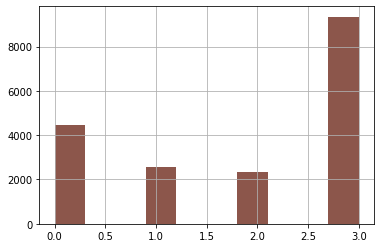

In [28]:
# cnn_model = Cnn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
nn_model = Nn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [35]:
weights = {'lbg': 0.5, 'cat': 0, 'xgb': 0.25, 'nn': 0.25}

final_pred = (lgb_model.y_pred * weights['lbg']) + (xgb_model.y_pred * weights['xgb']) + (nn_model.y_pred * weights['nn'])
#final_pred = cnn_model.y_pred
print(final_pred.shape)

(1000,)


In [30]:
pd.DataFrame([(round(a, 2), round(b, 2), round(c, 2), round(d, 2)) for a, b, c, d in zip(lgb_model.y_pred, cat_model.y_pred, xgb_model.y_pred, nn_model.y_pred)], columns=['lgb', 'cat', 'xgb', 'nn']).head(50)

NameError: name 'cat_model' is not defined

{0: 0.9552236090298515, 1: 1.7692779467722173, 2: 2.311149409893255}


3    0.500
0    0.239
1    0.136
2    0.125
Name: accuracy_group, dtype: float64

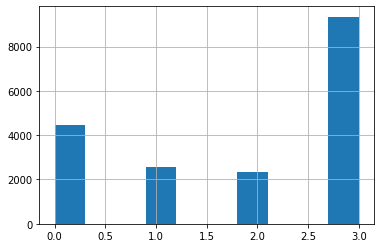

In [36]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)

3    0.498
0    0.239
1    0.137
2    0.126